In [1]:
import pandas as pd
import numpy as np
import os
import catomatic
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import requests, time

from protocols import utils

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'Helvetica'  
plt.rcParams['font.size'] =7 
plt.rcParams['figure.figsize'] = (6.69, 5.02)

%load_ext autoreload
%autoreload 2

# Methods notebook

This notebook generates, compares, and analyses the training and validation sets used in the Result notebook.

Firstly, before we analyse the data we need to add missing phenotypes to the tables (Kerri's new data):

In [2]:
val_data_1 = pd.read_csv("creating_training_validation_sets/validation_data_long_format_20250117.csv")
val_data_1

ena_run  ena_sample  ena_project     dataset           drug  \
0        ERR036186   ERS019735    PRJEB2358  validation            AMI   
1        ERR036187   ERS019744    PRJEB2358  validation            AMI   
2        ERR036188   ERS019745    PRJEB2358  validation            AMI   
3        ERR036189   ERS019746    PRJEB2358  validation            AMI   
4        ERR036190   ERS019736    PRJEB2358  validation            AMI   
...            ...         ...          ...         ...            ...   
196103  SRR9851584  SRS5170828  PRJNA557083  validation  thioacetazone   
196104  SRR9851585  SRS5170827  PRJNA557083  validation  thioacetazone   
196105  SRR9851586  SRS5170826  PRJNA557083  validation  thioacetazone   
196106  SRR9851587  SRS5170825  PRJNA557083  validation  thioacetazone   
196107  SRR9851588  SRS5170824  PRJNA557083  validation  thioacetazone   

       phenotype phenotype_quality  
0            NaN           Unknown  
1            NaN           Unknown  
2            NaN           Unknown  
3            NaN           Unknown  
4            NaN           Unknown  
...          ...               ...  
196103       NaN           Unknown  
196104       NaN           Unknown  
196105       NaN           Unknown  
196106       NaN           Unknown  
196107       NaN           Unknown  

[196108 rows x 7 columns]

In [3]:
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
crypticv3 = crypticv3[crypticv3.in_final_tables]
v3_pheno = pd.read_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS.pkl.gz').reset_index()

val_data_1 = pd.read_csv("creating_training_validation_sets/validation_data_long_format_20250117.csv")
val_data_2 = pd.read_csv("creating_training_validation_sets/training_data_long_format_20250117.csv")
    
methods = {"PRJNA353873": "MGIT",
    "PRJNA413593": "MGIT",
    "PRJNA438921": "MGIT",
    "PRJNA557083": "MGIT",
    "PRJNA650381": "MGIT960",
    "PRJNA663350": "MGIT",
    "PRJNA717733": "MGIT",
    "PRJNA821424": "MGIT",
    "PRJNA834625": "LJ",
    "PRJNA888434": "MGIT"}

def process_validation_data(df):
    df = df.merge(crypticv3[["UNIQUEID", "run_accession"]], left_on="ena_run", right_on="run_accession", how="left")
    df = df[~df.UNIQUEID.isin(v3_pheno.UNIQUEID.unique())].rename(
        columns={"phenotype_quality": "QUALITY", "phenotype": "PHENOTYPE", "drug": "DRUG"}
    )[['UNIQUEID', 'DRUG', 'PHENOTYPE', 'QUALITY', 'ena_project']]

    df['METHOD_3'] = [methods.get(proj, np.nan) for proj in df['ena_project']]

    for col in ['SOURCE', 'METHOD_1', 'METHOD_2', 'METHOD_CC', 'METHOD_MIC']:
        df[col] = np.nan
    return df

val_data_1 = process_validation_data(val_data_1)
val_data_2 = process_validation_data(val_data_2)

#write out phenotypes of validation set so they can be added to the cryptic tables
#missing most metadata - 'methods' dict is an attempt, but it will take ages to track down those details. 
#MICs may be worthwhile though, but again, I can't easily find them.
pd.concat([val_data_1, val_data_2]).to_csv('data/validation_phenotypes.csv')

v3_pheno = pd.concat([v3_pheno, val_data_1, val_data_2], ignore_index=True).drop(columns='ena_project')
v3_pheno.to_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl')

The CRyPTIC v3.1.0 tables are also missing 2495 samples that are in CRyPTIC v1.0, and we need to add these back in to compare fairly with WHOv1 (and only use 1 set of tables (v3.1.0) for the whole analysis)

In [4]:
v1_pheno = pd.read_pickle('data/cryptic-tables-v1/DST_MEASUREMENTS.pkl.gz').reset_index()
v1_geno = pd.read_pickle('data/cryptic-tables-v1/GENOMES.pkl.gz').reset_index()
crypticv1 = pd.merge(v1_pheno, v1_geno, on=['UNIQUEID'], how='inner')

v3_pheno = pd.read_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl').reset_index()
v3_geno = pd.read_parquet('data/cryptic-tables-v3.1.0/GENOMES.parquet').reset_index()
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()

missing_ids = list(set(crypticv1['UNIQUEID']) - set(crypticv3['UNIQUEID']))

print ('no. of missing samples in v3.1.0 with genomes:', v3_geno[v3_geno.UNIQUEID.isin(missing_ids)].UNIQUEID.nunique())
print ('no. of missing samples in v3.1.0 with phenotypes:', v3_pheno[v3_pheno.UNIQUEID.isin(missing_ids)].UNIQUEID.nunique())

#add rows to genomes table
missing = v1_geno[v1_geno.UNIQUEID.isin(missing_ids)][['UNIQUEID', 'SPECIES', 'LINEAGE_NAME', 'SUBLINEAGE_NAME']].rename(columns={'LINEAGE_NAME':'LINEAGE', 'SUBLINEAGE_NAME':'SUBLINEAGE'})
for col in v3_geno.columns:
    if col not in missing.columns:
        missing[col] = np.nan
v3_geno = pd.concat([v3_geno, missing], ignore_index=True)

v3_geno.to_parquet('data/cryptic-tables-v3.1.0/GENOMES_+.parquet')

#add rows to WGS_samples tables
missing = {'UNIQUEID':missing_ids, 'in_final_tables':[True for i in missing_ids], 'dataset':['CRyPTIC-v1.0' for i in missing_ids]}
missing = pd.DataFrame(missing)
for col in crypticv3.columns:
    if col not in missing.columns:
        missing[col] = np.nan

crypticv3 = pd.concat([crypticv3, missing], ignore_index=True)
crypticv3 = crypticv3.sort_values(by='in_final_tables', ascending=False) 
crypticv3 = crypticv3.drop_duplicates(subset=['UNIQUEID'], keep='first')

crypticv3.to_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES_+.parquet')

#add rows to mutations table
print ('\nmissing samples with ena accessions:', len(v1_geno[(v1_geno.UNIQUEID.isin(missing_ids))&(~v1_geno.ENA.isna())]))


no. of missing samples in v3.1.0 with genomes: 0
no. of missing samples in v3.1.0 with phenotypes: 2455

missing samples with ena accessions: 110


In [5]:
column_names = [
    'run_accession', 'country:location', 'unknown', 'first_public',
    'study_accession', 'sample_accession', 'center_name',
    'fastq_ftp', 'fastq_md5', 'fastq_bytes'
]

def call_ena(sample_accession):
    time.sleep(0.005)
    request_url = 'https://www.ebi.ac.uk/ena/portal/api/filereport?accession='+sample_accession+'&result=read_run&fields=center_name,country,location,first_public,study_accession,sample_accession,run_accession,fastq_ftp,fastq_md5,fastq_bytes&limit=10000000'
    r = requests.get(request_url)
    rows = []
    first_line = True
    for i in r.text.split('\n'):
        row = i.split('\t')
        if first_line:        
            first_line = False
        else:
            rows.append(row)
    return rows

def build_ena_table(data):
    results = []
    for index, row in data.iterrows():
        accession = row['ENA_accession']
        ena_data = call_ena(accession)
        if ena_data:
            ena_df = pd.DataFrame(ena_data, columns=column_names)
            ena_df['UNIQUEID'] = row['UNIQUEID']
            results.append(ena_df)

    return pd.concat(results, ignore_index=True)

def calculate_total_bytes(value):
    if value == '':  
        return 1
    try:
        values = list(map(int, value.split(';')))
        return sum(values) 
    except ValueError:
        return 1  


In [6]:
accessions = []
for i in v1_geno.index:
    if pd.isna(v1_geno['ENA'][i]):
        if 'ENA' in v1_geno['UNIQUEID'][i]:
            accessions.append(v1_geno['UNIQUEID'][i].split('.')[3])
        else:
            accessions.append('None')
    else:
        accessions.append(v1_geno['ENA'][i])

v1_geno['ENA_accession'] = accessions

In [7]:
missing_data = build_ena_table(v1_geno[(v1_geno.UNIQUEID.isin(missing_ids)&(~v1_geno.ENA_accession.isin(['None', 'NO_ENA'])))])
missing_data = missing_data[missing_data.run_accession!='']
missing_data['total_bytes'] = missing_data['fastq_bytes'].apply(calculate_total_bytes)
missing_data = missing_data.loc[missing_data.groupby('sample_accession')['total_bytes'].idxmax()]

missing_data

KeyboardInterrupt: 

In [17]:
missing_data.to_csv('data/v1_data_missing_from_v3.csv')

In [19]:
v1_geno[(v1_geno.UNIQUEID.isin(missing_ids)&(v1_geno.ENA_accession.isin(['None', 'NO_ENA'])))].to_csv('data/v1_data_missing_from_v3_no_ena.csv')

This table is the ena data for ~2000 of the validation samples, to be processed. Still missing 500 though, and not sure where to find them.

In [39]:
q = v1_pheno[v1_pheno.UNIQUEID.isin(missing_ids)&(v1_pheno.DRUG=='MXF')]
q = q.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)

q.PHENOTYPE.value_counts()

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_33700/891854735.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  q = q.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


PHENOTYPE
S    1607
U     253
R     140
Name: count, dtype: int64

Missing samples and genomes from v1 added to v3.1.0.

Still need to add mutations - but to do this, also need to add to variants table and calcualte FRS. This is a real pain - would make more sense to give philip ids so we can re-run those samples.

Issue is, only 110 of those ~2500 samples are in the ena...

In light of this, for now just use the original v3.1.0 WGS_SAMPLES.parqeut and GENOMES.parquet tables (but remember we are missing those 2495 samp)

We have 3 key datasets, which themselves are different cryptic releases:
- CRyPTIC v1 - the original cryptic release. Also used to build the WHO catalogue, and is therefore the only like-for-like dataset we have.
- CRyPTIC v3.1.0 - CRyPTIC v1 + a bunch of samples processed since then as part of the cryptic project + nearly 9000 (at the moment less than this as many are nanopore sequences) samples collected and collated independently of the cryptic project and uploaded to the ena with genomes.

It logically follows that we build an initial catalogue on CRyPTICv1 which we can compare contents and performance to WHOv1 like for like. 

We can then independently validate this on CRypTICv3.1.0 - CRypTICv1 (along with WHOv1).

We can then build and release the most up-to-date catalogue trainED on crypticv3.1.0. We can also validate on CRyPTICv3.1.0 - CRypTICv1, but the problem is we can't indepdnently validate this, so performance will be over-estimated. We can also compare performance to WHOv2 on this validation set (but we dont know what sampels went into WHOv2, so not necessarily indepdendent).

In [38]:
v1_pheno = pd.read_pickle('data/cryptic-tables-v1/DST_MEASUREMENTS.pkl.gz').reset_index()
v1_geno = pd.read_pickle('data/cryptic-tables-v1/GENOMES.pkl.gz').reset_index()
crypticv1 = pd.merge(v1_pheno, v1_geno, on=['UNIQUEID'], how='inner')

v3_pheno = pd.read_pickle('data/cryptic-tables-v3.1.0/DST_MEASUREMENTS_+.pkl').reset_index()
v3_geno = pd.read_parquet('data/cryptic-tables-v3.1.0/GENOMES.parquet').reset_index()
#v3_muts = pd.read_parquet('data/cryptic-tables-v3.1.0/MUTATIONS.parquet').reset_index()
crypticv3 = pd.read_parquet('data/cryptic-tables-v3.1.0/WGS_SAMPLES.parquet').reset_index()
crypticv3 = crypticv3[crypticv3.in_final_tables]
validation = crypticv3[crypticv3.dataset=='CRyPTIC-v3.0']

## Generate training set

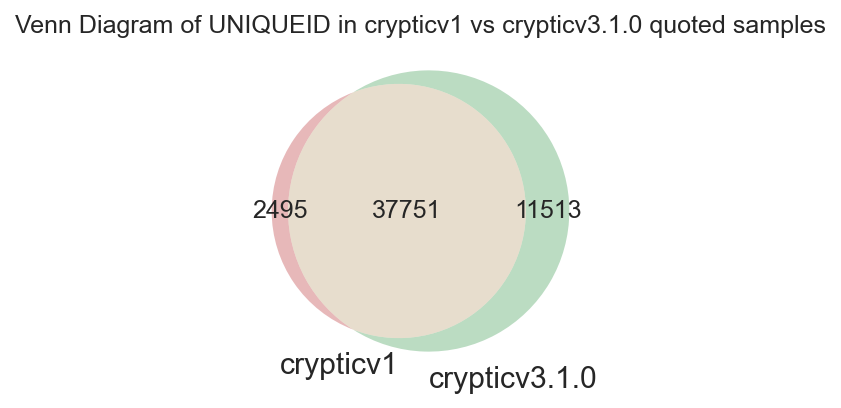

In [32]:
# Extract unique UNIQUEID from both datasets
set_v1 = set(crypticv1['UNIQUEID'])
set_v3 = set(crypticv3['UNIQUEID'])

# Calculate counts
shared_count = len(set_v1 & set_v3)  # Intersection
only_v1_count = len(set_v1 - set_v3)  # Unique to crypticv1
only_v3_count = len(set_v3 - set_v1)  # Unique to crypticv3

# Plot Venn diagram
plt.figure(figsize=(3, 3))
venn = venn2(subsets=(only_v1_count, only_v3_count, shared_count), 
             set_labels=('crypticv1', 'crypticv3.1.0'))

plt.title("Venn Diagram of UNIQUEID in crypticv1 vs crypticv3.1.0 quoted samples")
plt.show()


We are going to build 2 main catalogues on:
- cryptic v1
- cryptic v3.1.0

At present, the first will have 2495 variants not in the second, and the second will have 11513 samples not in the first.

For simplicity, we will use the v3.1.0 tables and subset using the 'dataset' column, although note, we will lose 2495 samples - we should probably put these back in.

Okay, v3 has the phenotypes for the missing v1 samples, but not genomes - lets add these in

In [33]:
missing.UNIQUEID.nunique()

2455

In [34]:
crypticv1.columns

Index(['index', 'UNIQUEID', 'DRUG', 'SOURCE', 'METHOD_1', 'METHOD_2',
       'METHOD_3', 'METHOD_CC', 'METHOD_MIC', 'PHENOTYPE', 'SITEID', 'SUBJID',
       'LABID', 'ISOLATENO', 'SEQREPS', 'BELONGS_GPI',
       'PER_SAMPLE_VCF_PRESENT', 'REGENOTYPED_VCF_PRESENT',
       'CLOCKWORK_VERSION', 'TBI_INDEX', 'KMER_COUNTS',
       'SNP_DISTANCE_TO_H37rV', 'SPECIES', 'LINEAGE_NAME', 'SUBLINEAGE_NAME',
       'LINEAGE_PERCENTAGE', 'N_NULL', 'N_SNP', 'N_INDEL', 'N_FILTER_FAIL',
       'N_REF', 'N_HET', 'CATALOGUE_NAME', 'CATALOGUE_VERSION', 'TB_TYPE_1',
       'WGS_PREDICTION_STRING', 'IMAGE_MD5SUM', 'FTP_PATH', 'FTP_FILENAME_VCF',
       'TREE_PATH', 'TREE_FILENAME_VCF', 'FASTQ_MD5SUMS', 'SEQTREAT_SAMPLE',
       'MYKROBE_LINEAGE_NAME_1', 'MYKROBE_LINEAGE_NAME_2', 'ENA'],
      dtype='object')

In [35]:
crypticv3.columns

Index(['UNIQUEID', 'run_accession', 'study_accession', 'sample_accession',
       'center_name', 'country', 'location', 'first_public', 'fastq_ftp',
       'fastq_md5', 'fastq_bytes', 'has_effects', 'has_mutations',
       'has_predictions', 'has_genome', 'status',
       'has_multiple_ena_run_accessions', 'pathogena_sample_name',
       'pathogena_batch_name', 'pathogena_batch_id', 'in_mapping_file',
       'group', 'in_final_tables', 'dataset'],
      dtype='object')

#  Training Data

In [36]:
crypticv1 = crypticv3[crypticv3.dataset=='CRyPTIC-v1.0']
phenotypes = v3_pheno[v3_pheno.UNIQUEID.isin(crypticv1.UNIQUEID.unique())]
phenotypes = phenotypes[~phenotypes.DRUG.isin([ 'MPM','CYC','IMI','DCS','GEN','GFX','CLR'])]
phenotypes = phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_33700/1075040919.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes = phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


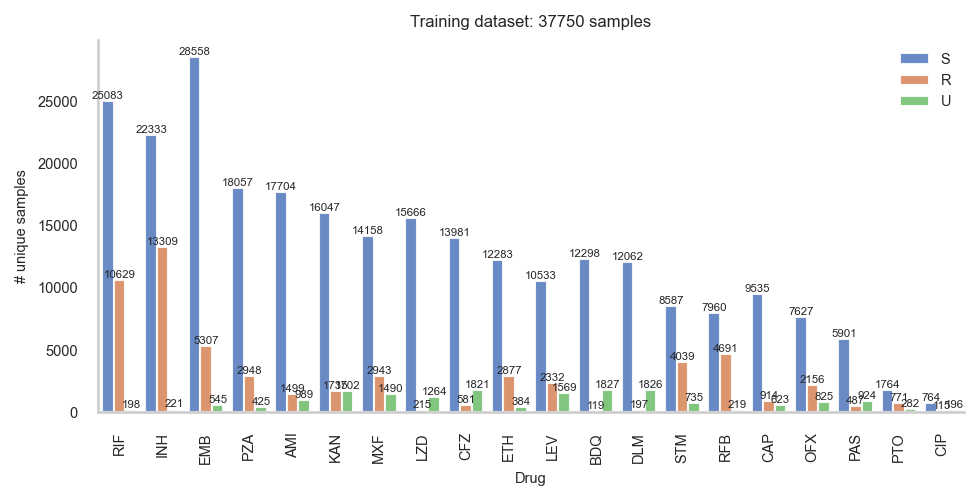

In [37]:
utils.plot_pheno_counts(phenotypes, 'Training dataset', savefig='figs/data/training_samples.pdf')

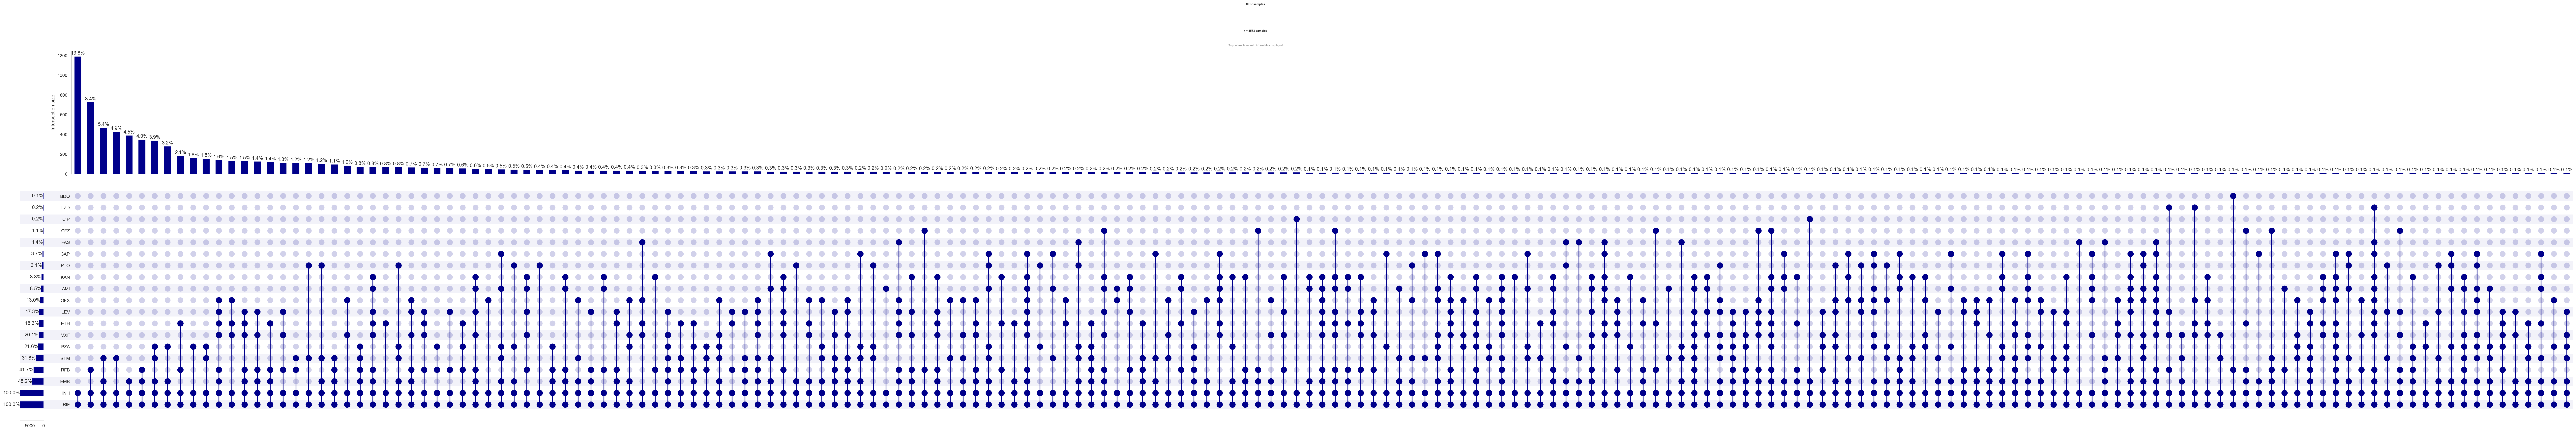

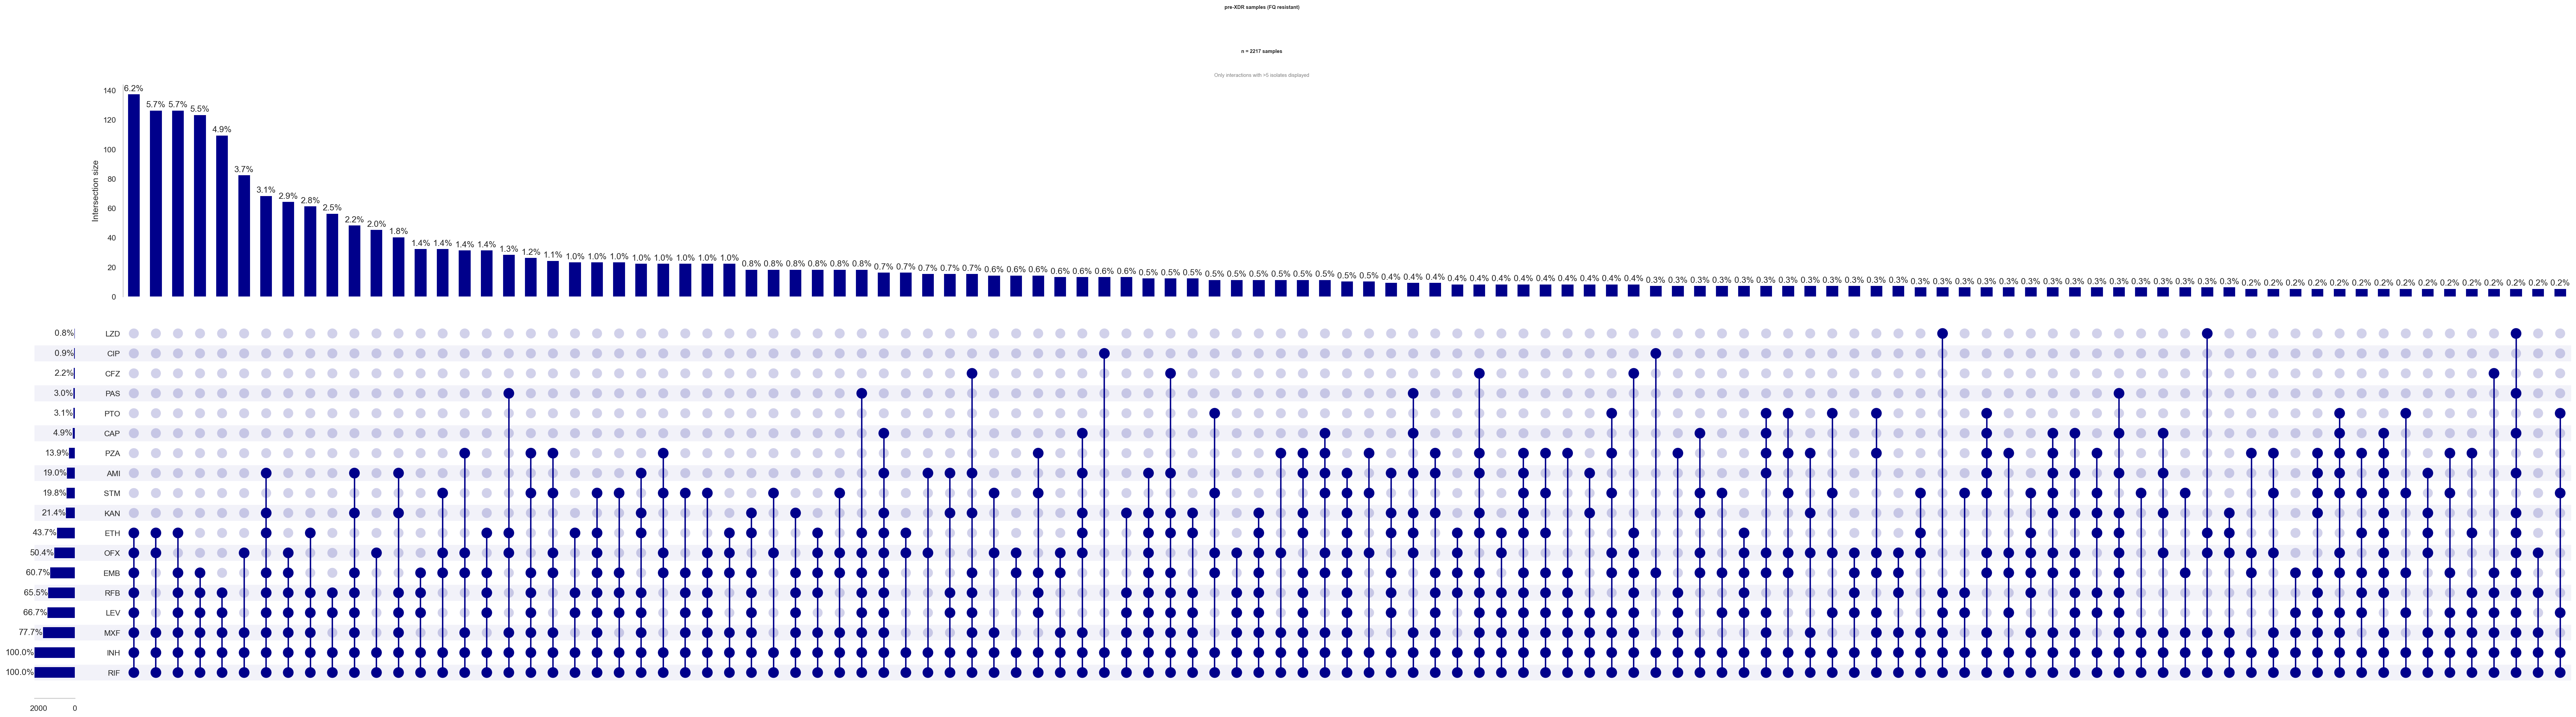

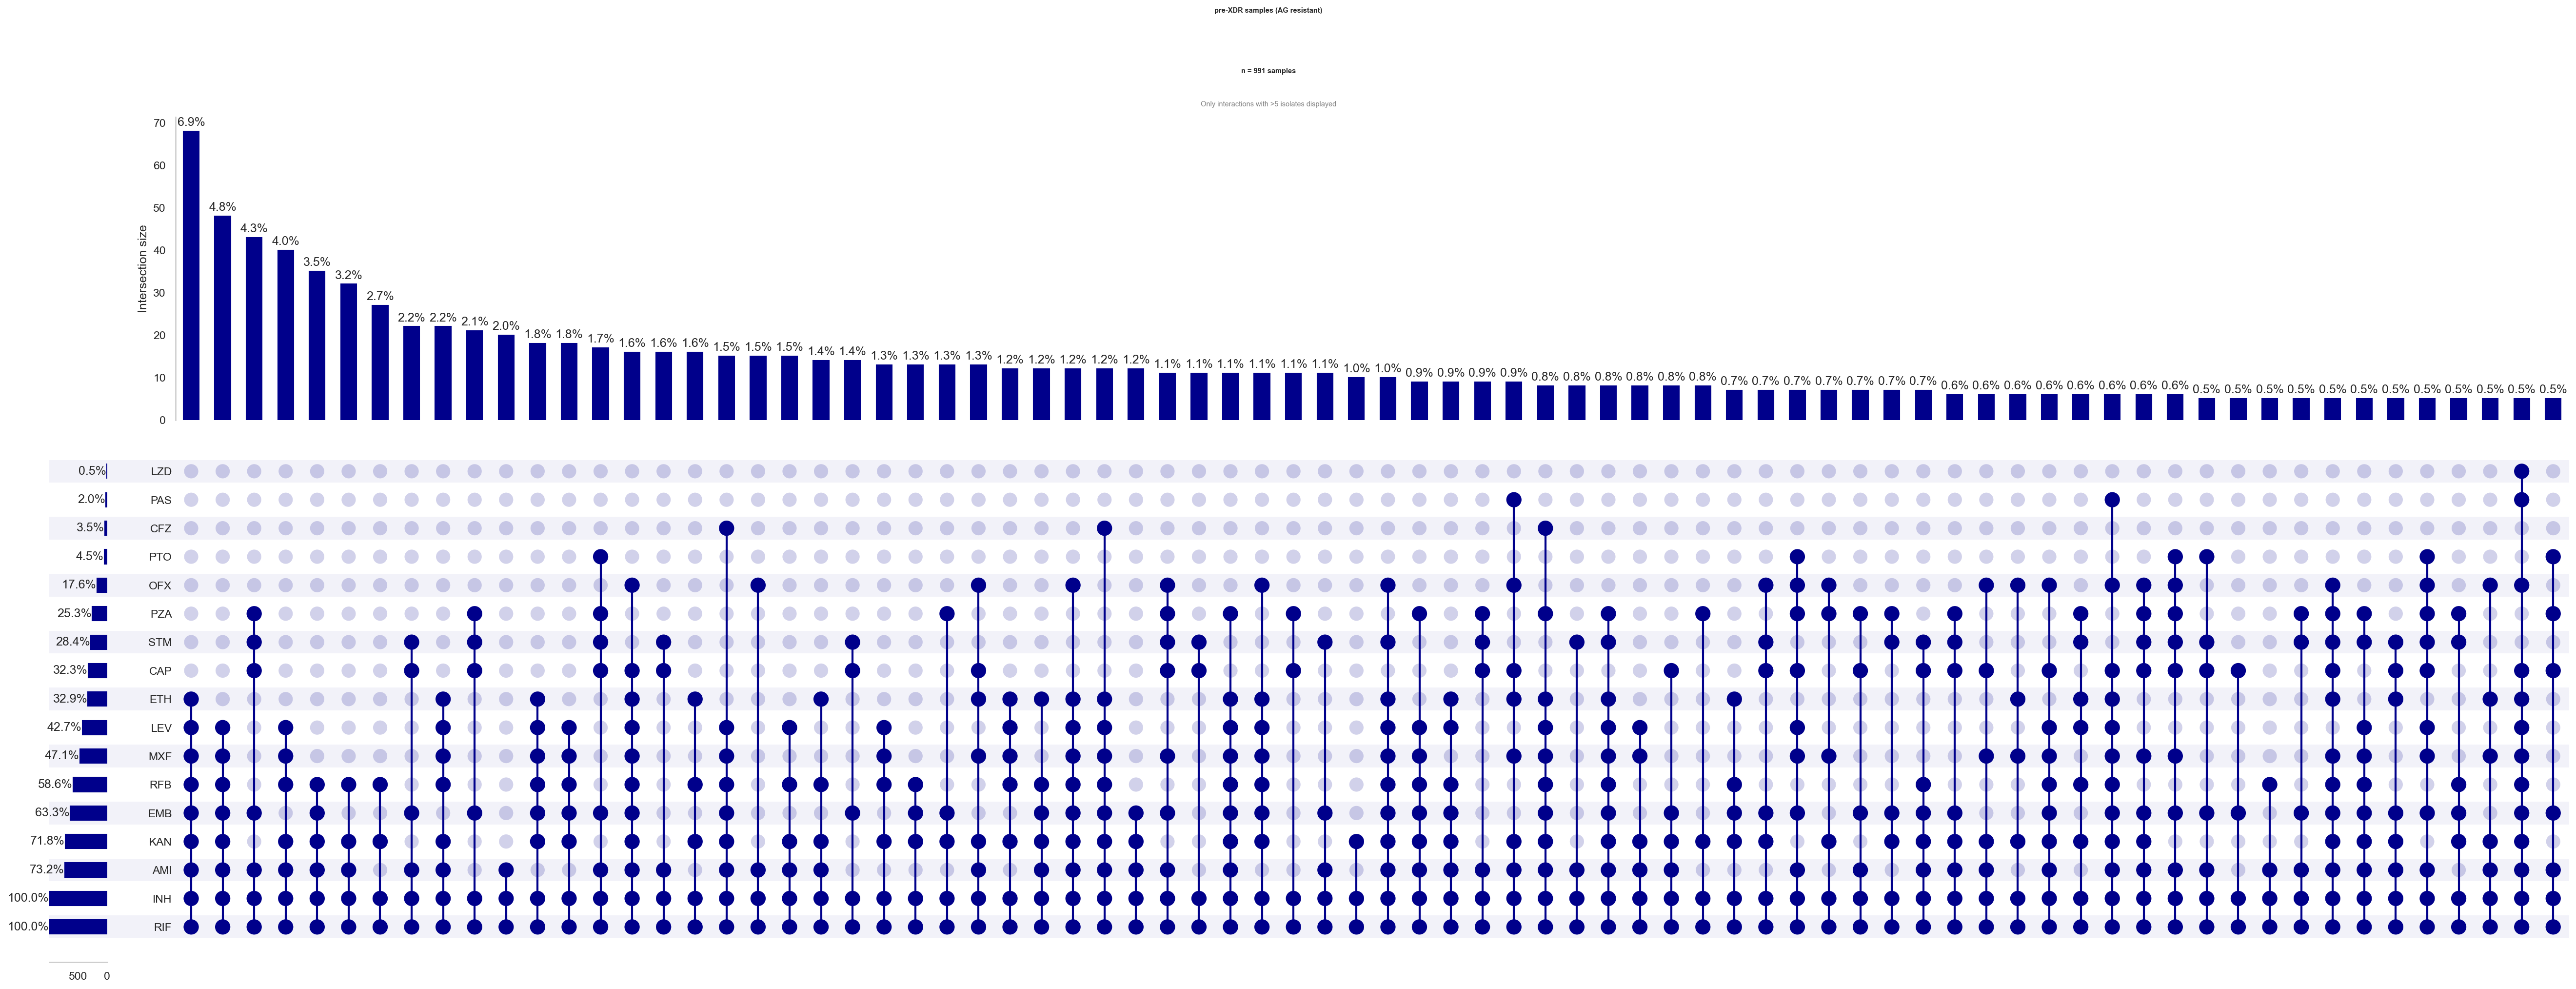

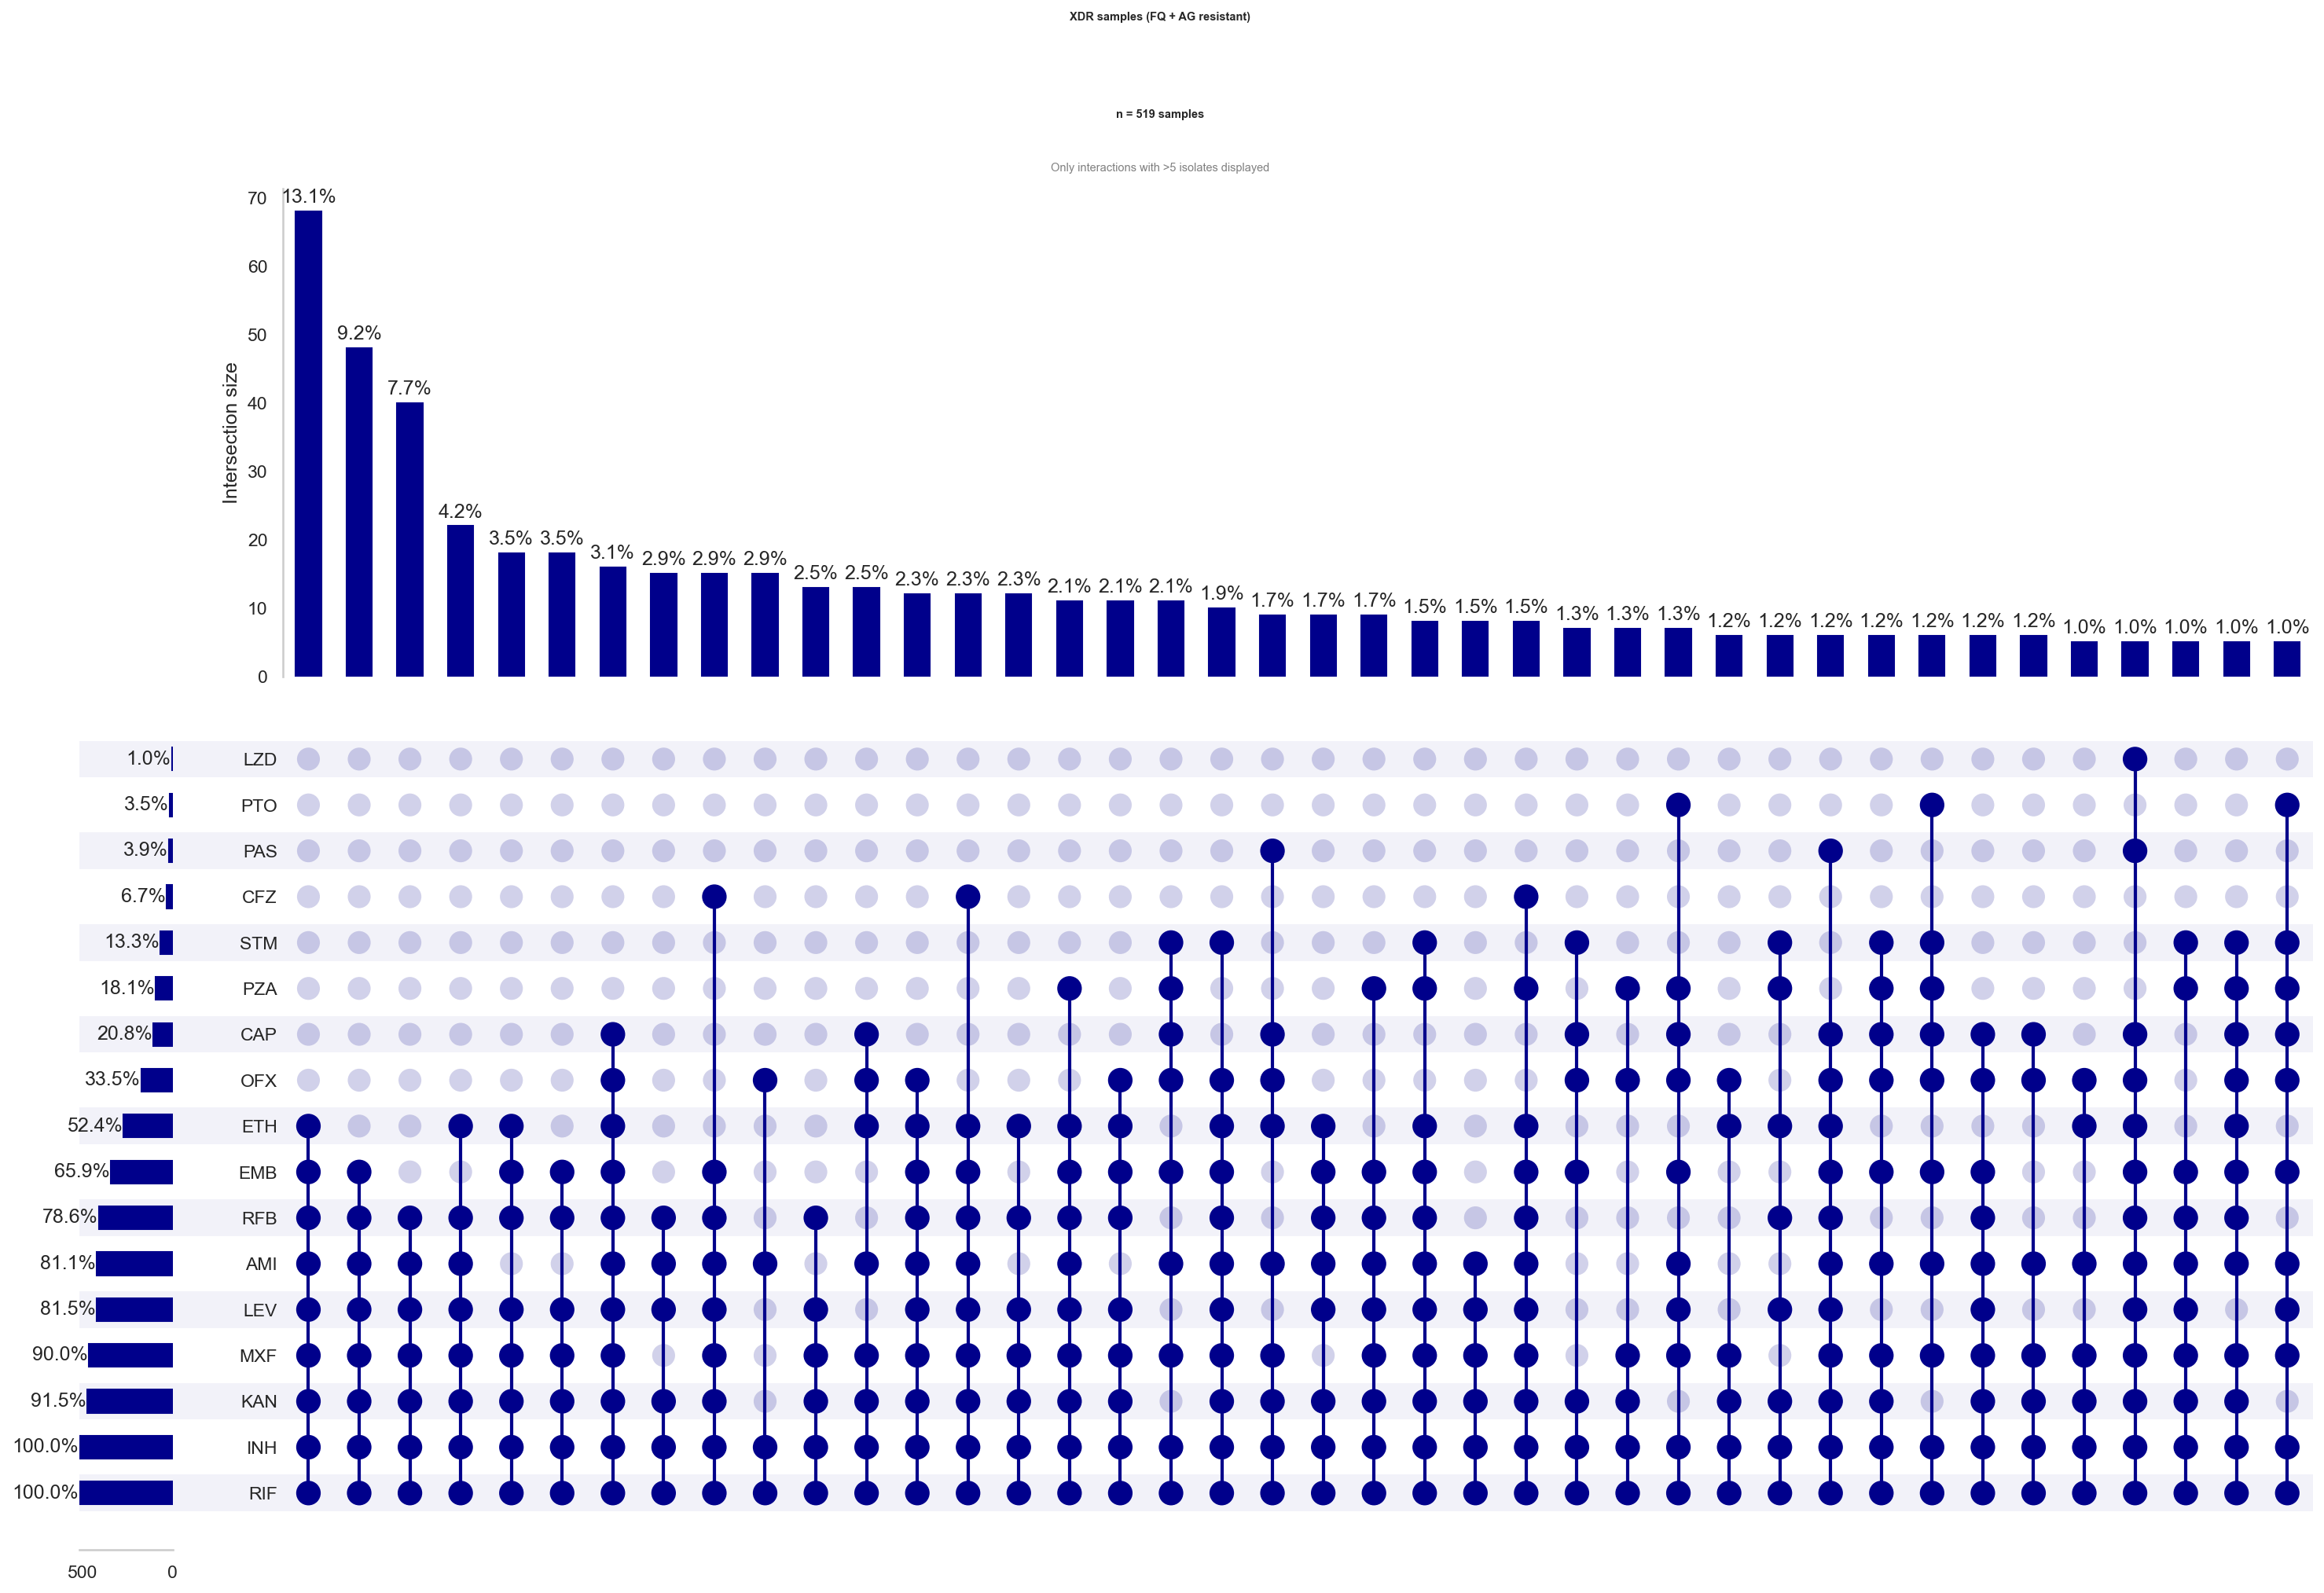

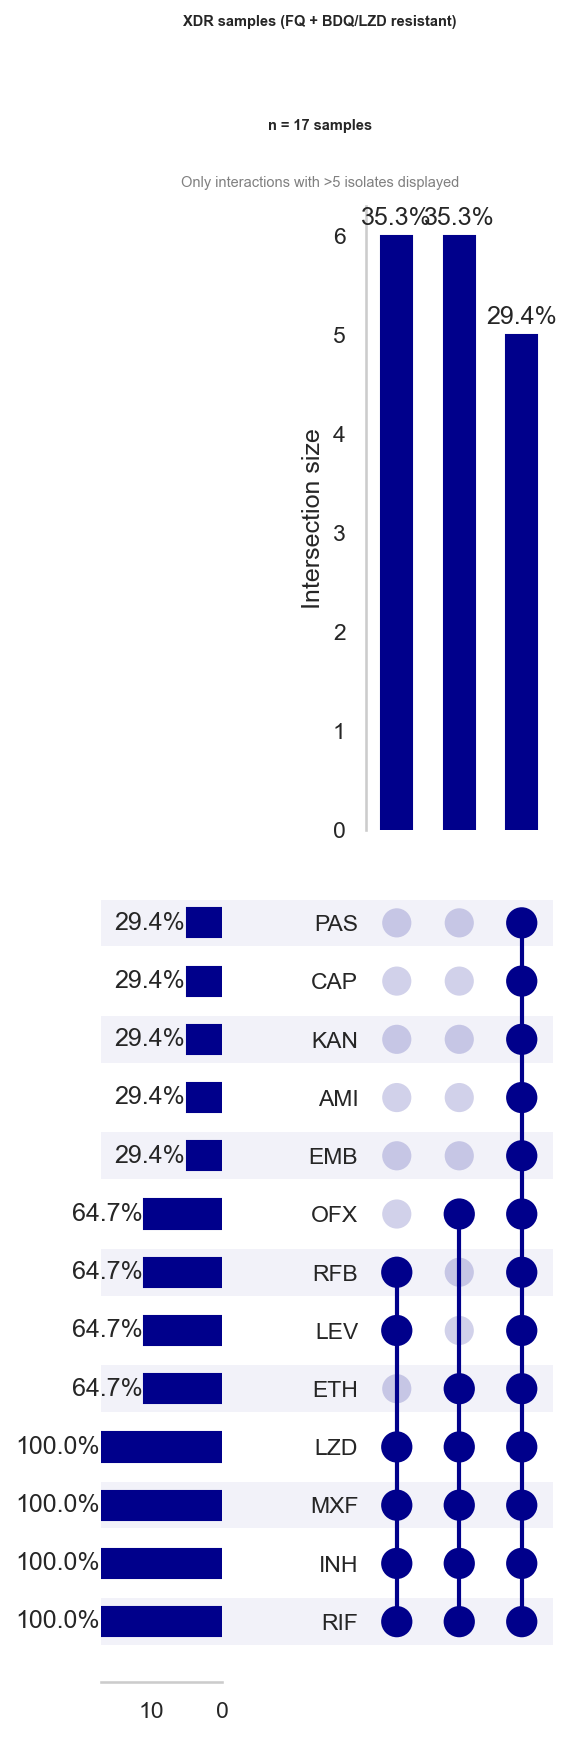

In [15]:
training_pivot = phenotypes.pivot(index="UNIQUEID", columns="DRUG", values=["PHENOTYPE"])

training_pivot.reset_index(inplace=True)

if isinstance(training_pivot.columns, pd.MultiIndex):
    training_pivot.columns = [col[1] if isinstance(col, tuple) else col for col in training_pivot.columns]
training_pivot_cleaned = training_pivot.fillna("")

for col in training_pivot_cleaned.columns[1:]:  # Skipping UNIQUEID
    training_pivot_cleaned[col] = training_pivot_cleaned[col].apply(lambda x: 1 if x == "R" else 0)

if "UNIQUEID" in training_pivot_cleaned.columns:
    training_pivot_cleaned.set_index("UNIQUEID", inplace=True)

training_pivot_cleaned.reset_index(inplace=True, drop=True)

total_counts = (
   phenotypes.groupby(['DRUG', 'PHENOTYPE'])['UNIQUEID']
    .nunique()
    .reset_index()
    .rename(columns={'UNIQUEID': 'count'})
).groupby('DRUG')['count'].sum().reset_index()

# Order DRUGs by total count descending
plot_order = total_counts.sort_values('count', ascending=False)['DRUG'].tolist()

# 1. MDR = RIF + INH
mdr_data, n_samples_mdr = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R'",
    plot_order
)
utils.create_upset_plot(mdr_data, "MDR samples", n_samples_mdr, f"./pdfs/MDR_training_upset_plot_20240117.pdf")

# 2. pre-XDR TB (FQ resistant)
preXDR_FQ_data, n_samples_preXDR_FQ = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_FQ_data, "pre-XDR samples (FQ resistant)", n_samples_preXDR_FQ, f"./pdfs/preXDR_FQ_training_upset_plot_20240117.pdf")

# 3. pre-XDR TB (AG resistant)
preXDR_AG_data, n_samples_preXDR_AG = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_AG_data, "pre-XDR samples (AG resistant)", n_samples_preXDR_AG, f"./pdfs/preXDR_AG_training_upset_plot_20240117.pdf")

# 4. XDR TB (FQ + AG resistant)
XDR_data, n_samples_XDR = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_data, "XDR samples (FQ + AG resistant)", n_samples_XDR, f"./pdfs/XDR_FQ_AG_training_upset_plot_20240117.pdf")

# 5. XDR TB (FQ + BDQ/LZD resistant)
XDR_BL_data, n_samples_XDR_BL = utils.prepare_upset_data(
    training_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OFX == 'R' | LEV == 'R' | CIP == 'R') & (BDQ == 'R' | LZD == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_BL_data, "XDR samples (FQ + BDQ/LZD resistant)", n_samples_XDR_BL, f"./pdfs/XDR_FQ_BDQ_LZD_training_upset_plot_20240117.pdf")


# v3.0 training set

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_33700/2062896724.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  phenotypes = phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


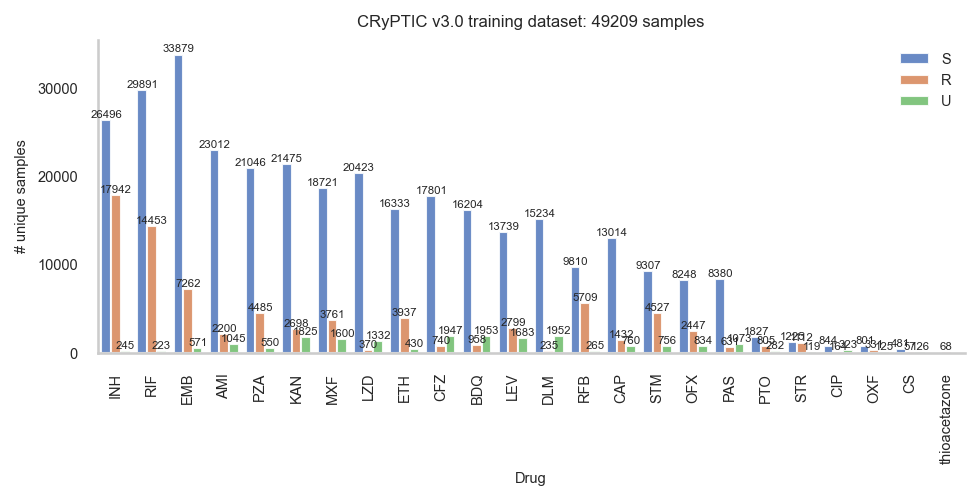

In [42]:
phenotypes = v3_pheno[v3_pheno.UNIQUEID.isin(crypticv3.UNIQUEID.unique())]
phenotypes = phenotypes[~phenotypes.DRUG.isin([ 'MPM','CYC','IMI','DCS','GEN','GFX','CLR'])]
phenotypes = phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)

utils.plot_pheno_counts(phenotypes, 'CRyPTIC v3.0 training dataset', savefig='figs/data/training_samples_v3.pdf')

#  Validation Data

In [18]:
val_phenotypes = v3_pheno[v3_pheno.UNIQUEID.isin(validation.UNIQUEID.unique())]
val_phenotypes = val_phenotypes[~val_phenotypes.DRUG.isin([ 'MPM','CYC','IMI','DCS','GEN','GFX','CLR'])]
val_phenotypes = val_phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_33700/515480598.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_phenotypes = val_phenotypes.groupby(["UNIQUEID", "DRUG"], group_keys=False).apply(utils.filter_multiple_phenos)


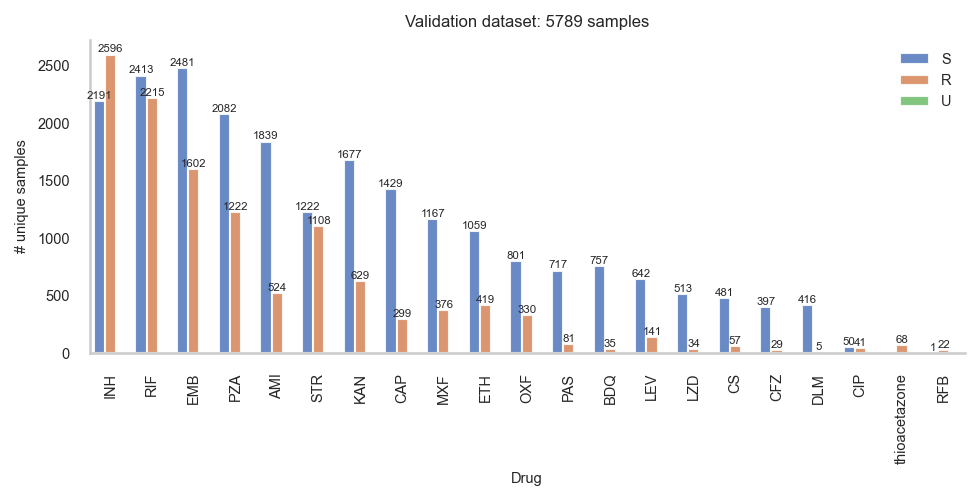

In [19]:
utils.plot_pheno_counts(val_phenotypes, 'Validation dataset', savefig='figs/data/validation_samples.pdf')

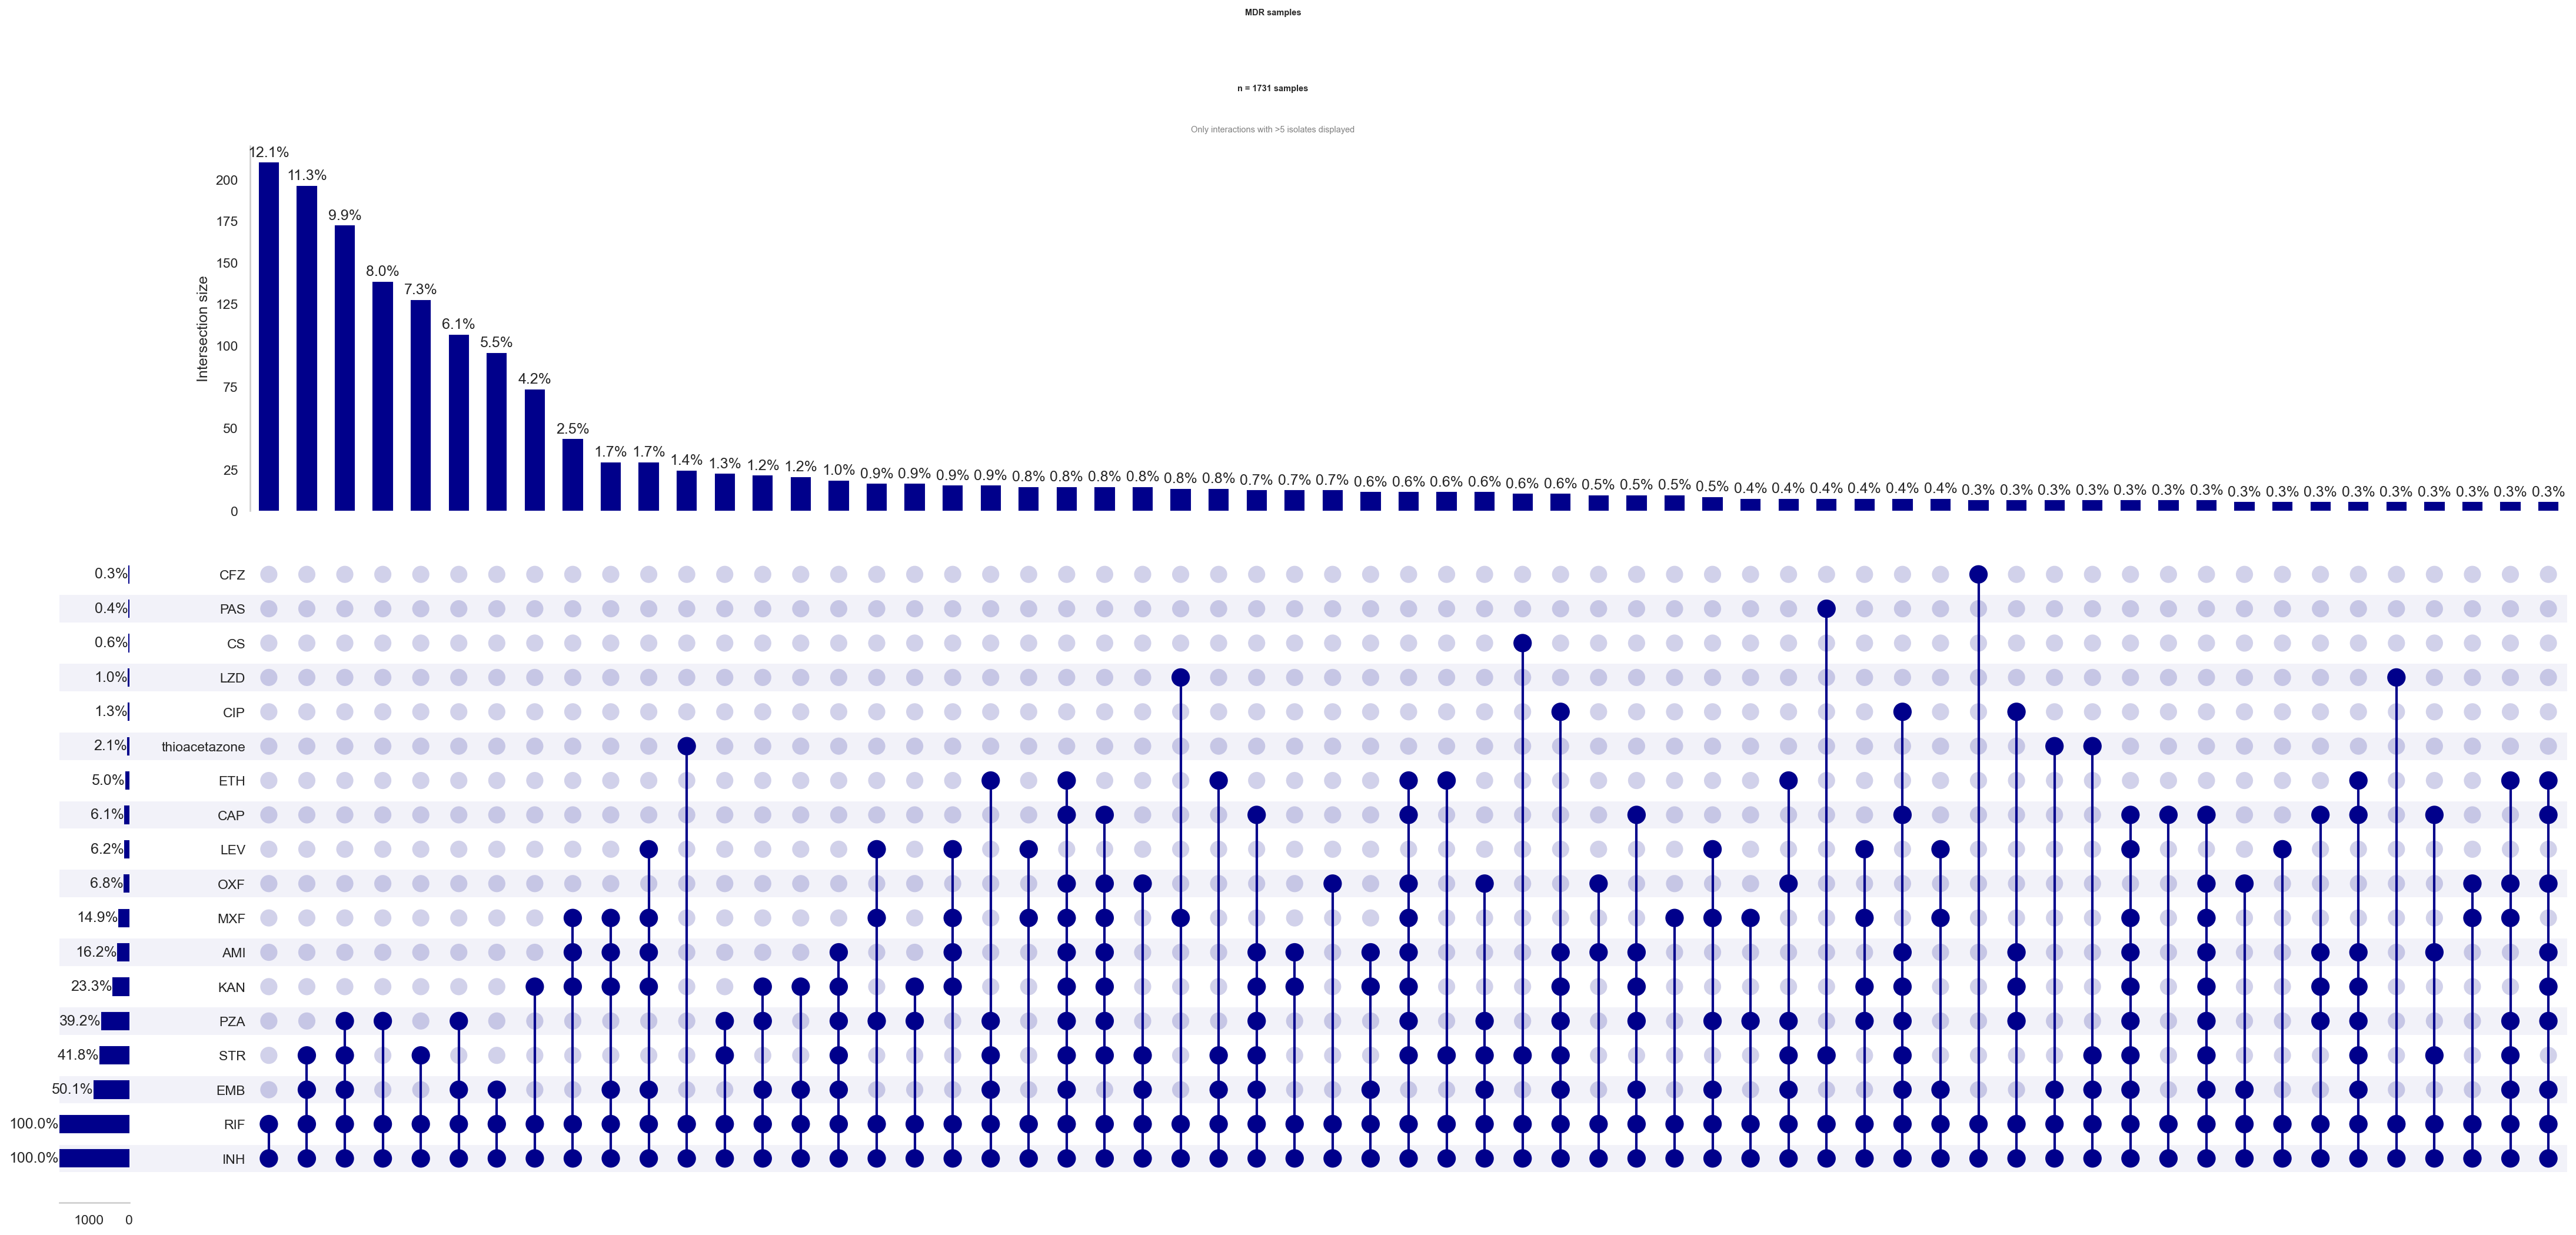

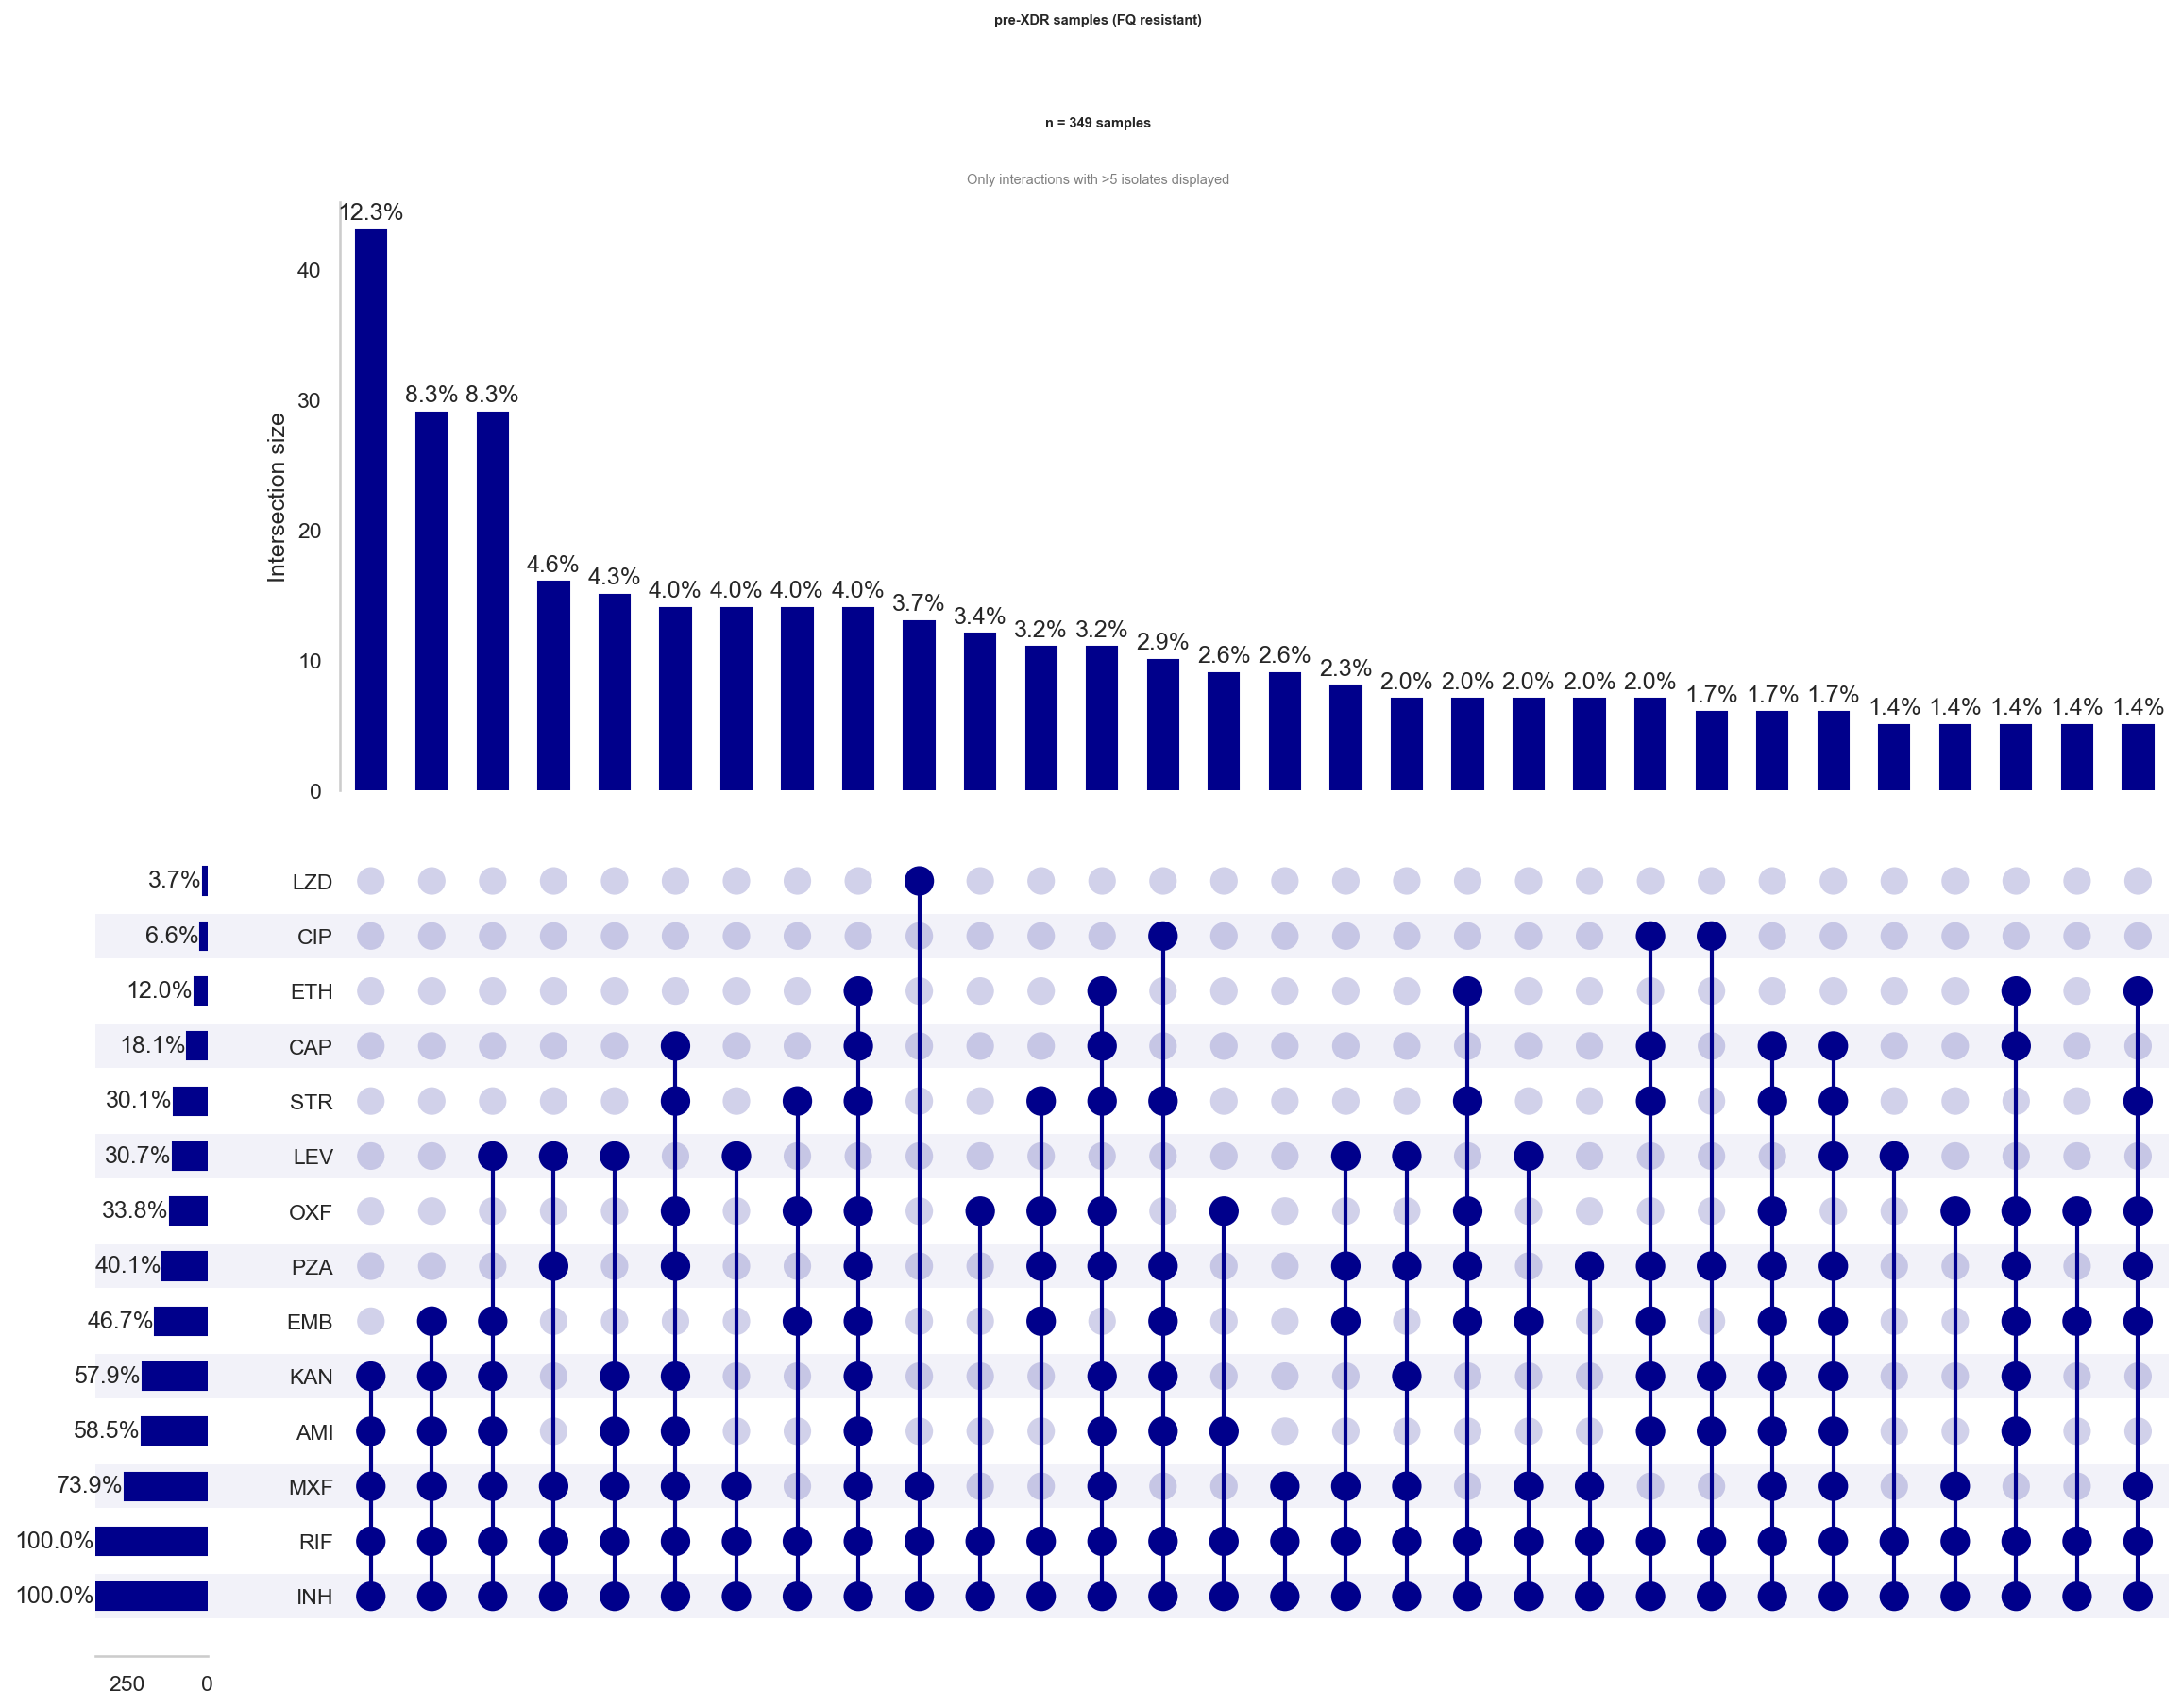

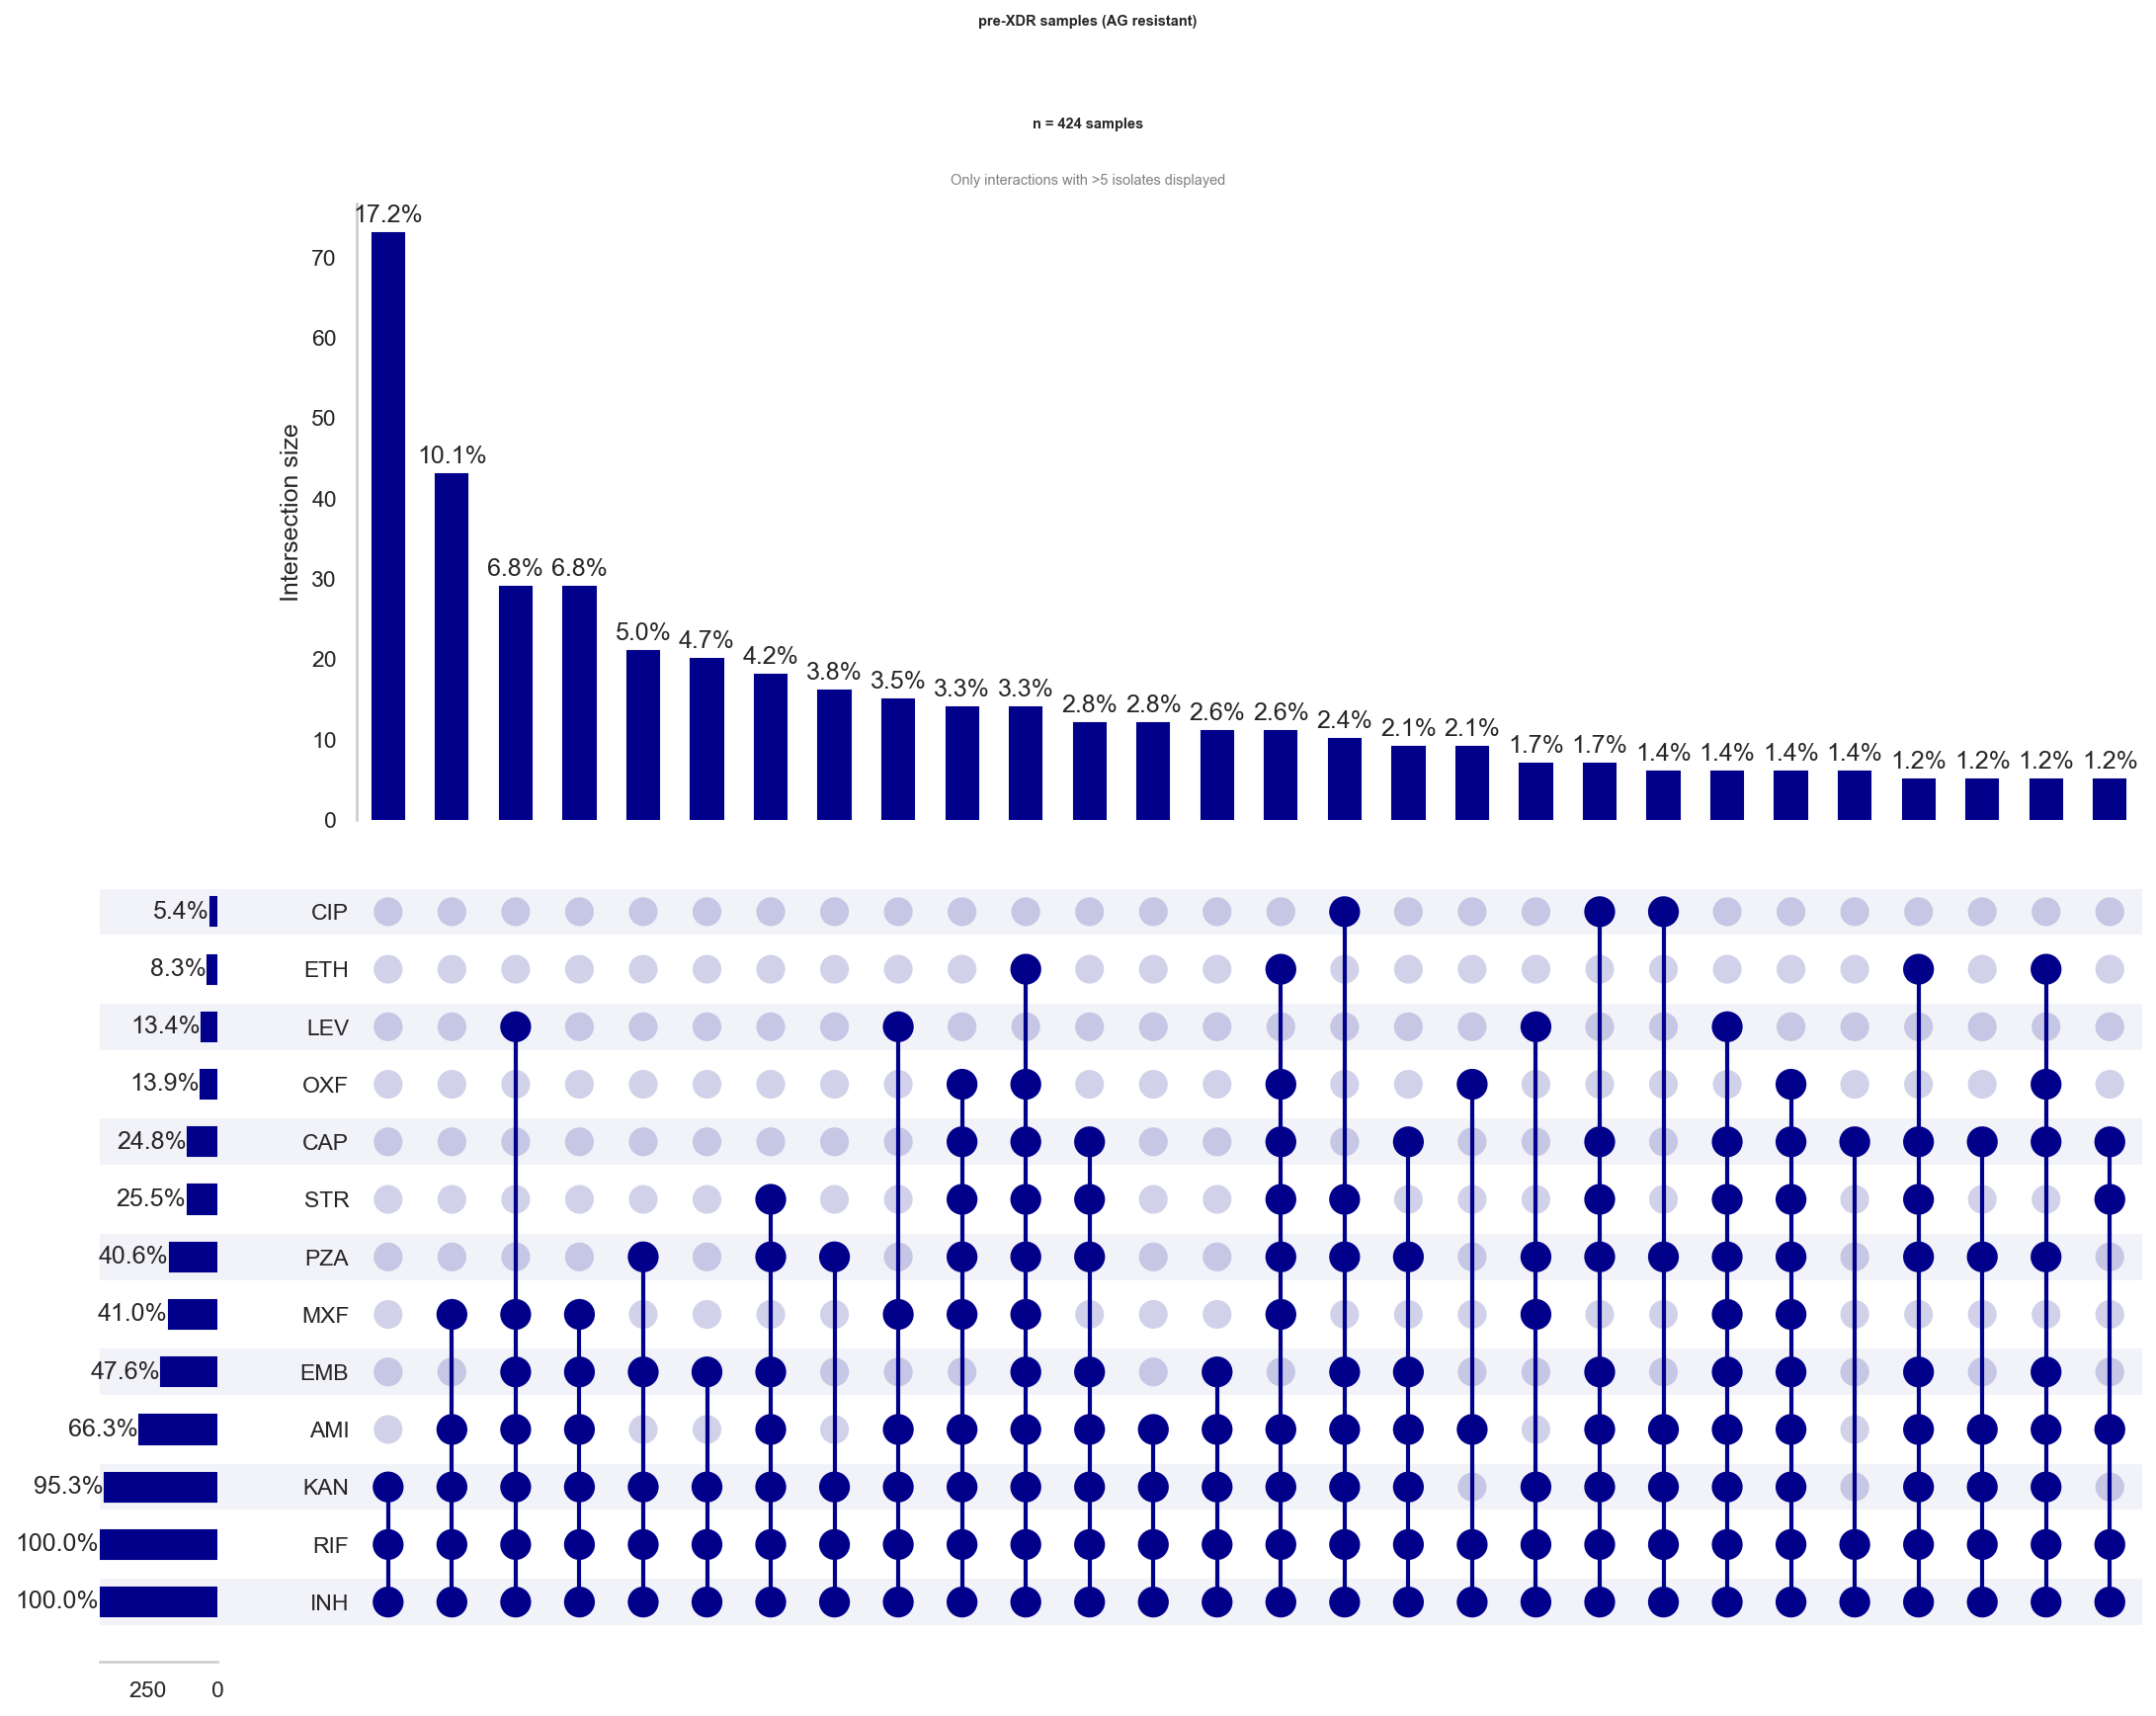

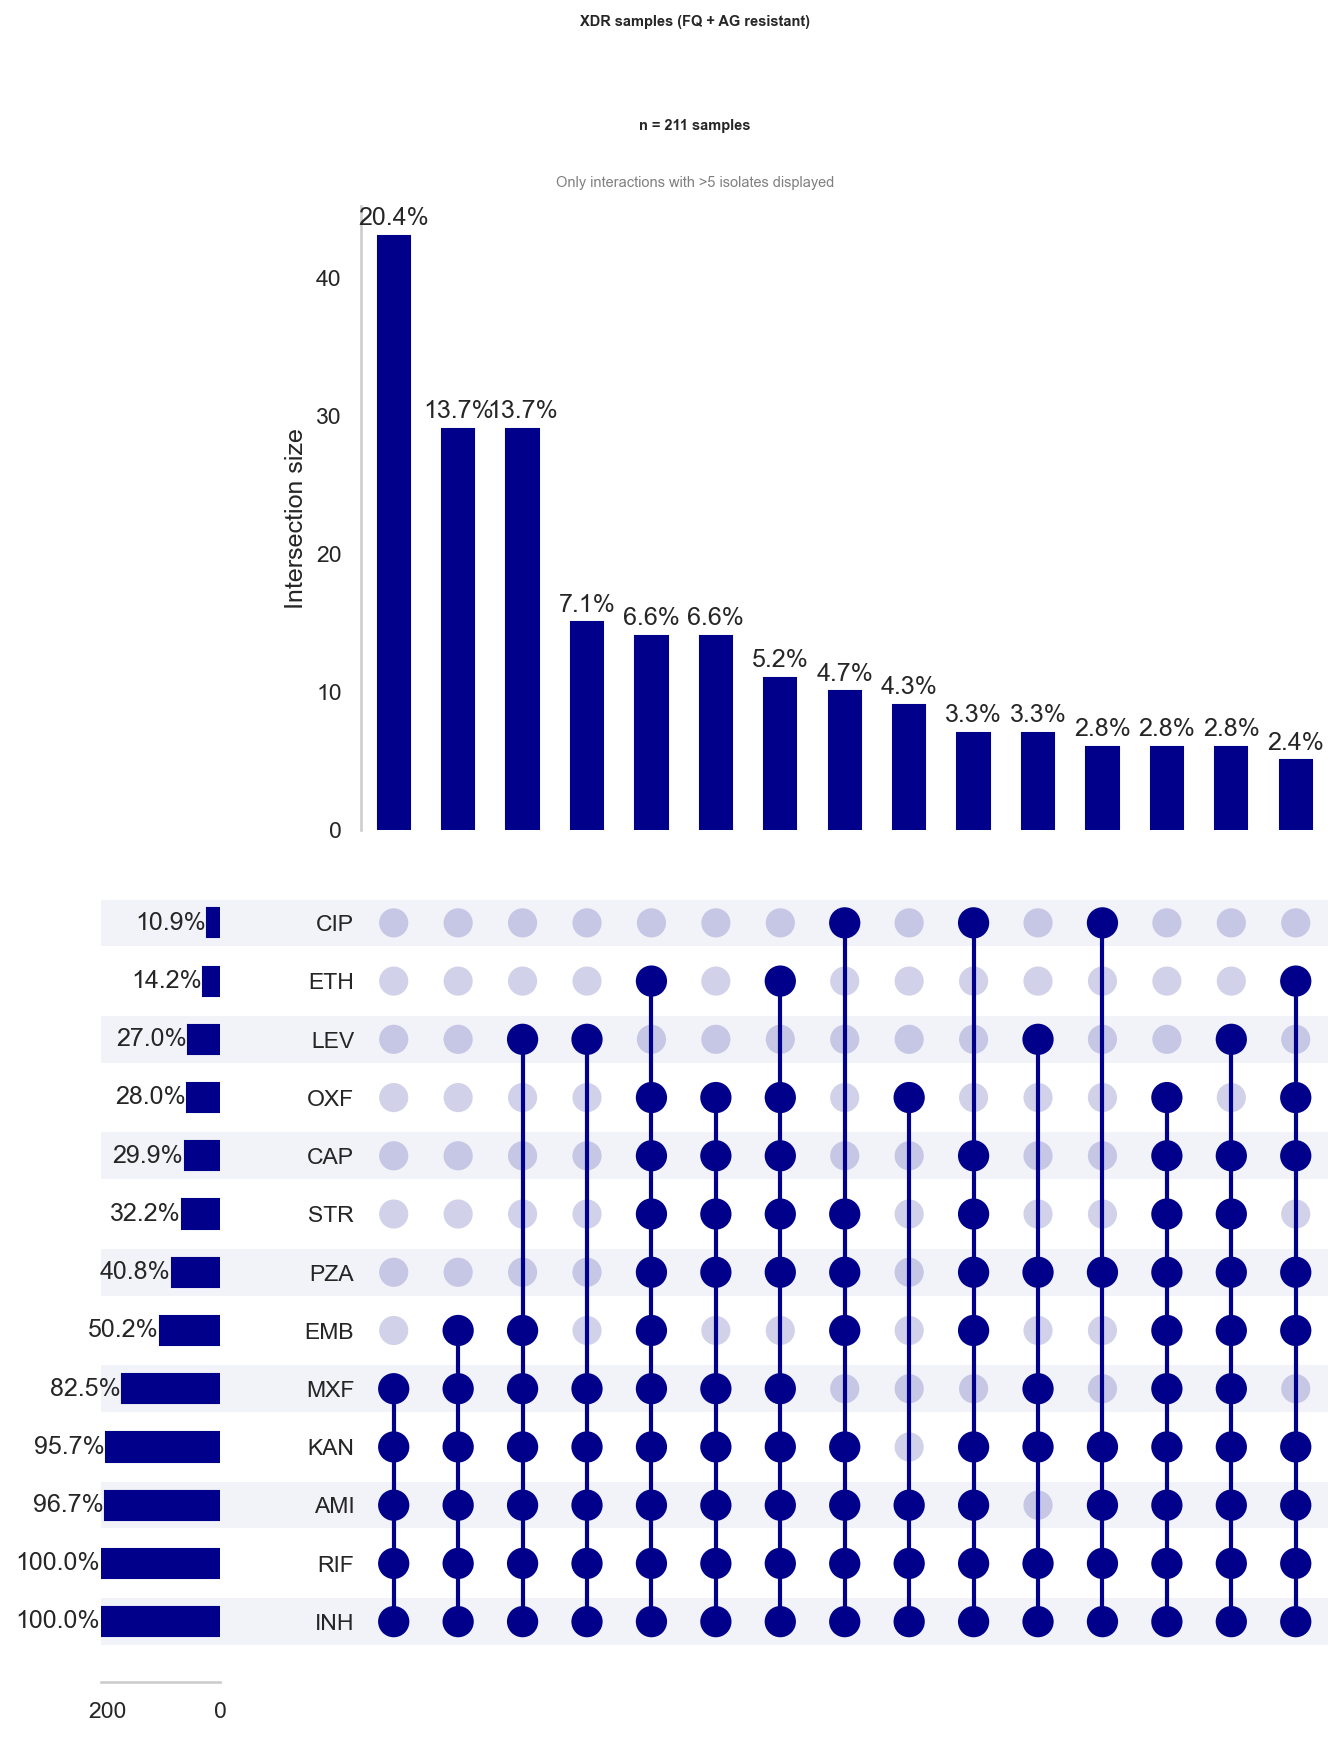

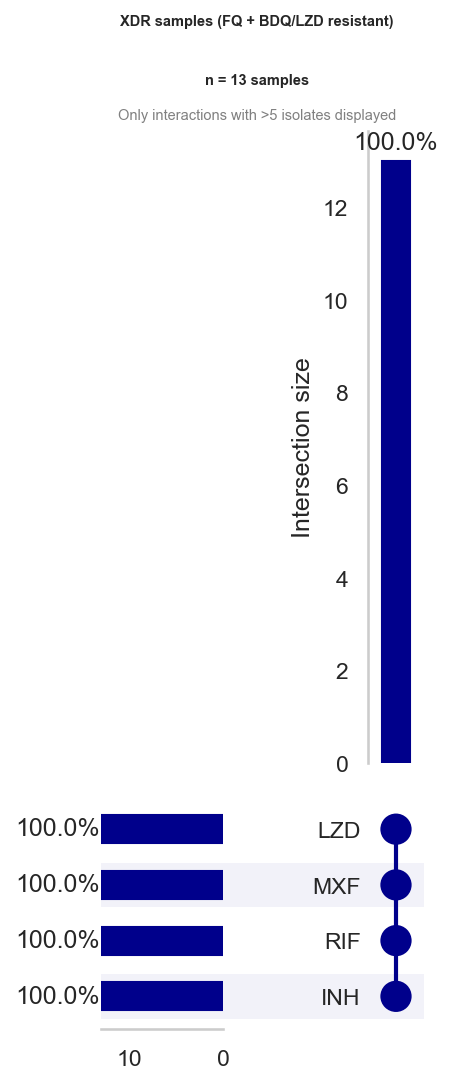

In [42]:
validation_pivot = val_phenotypes.pivot(index="UNIQUEID", columns="DRUG", values=["PHENOTYPE"])

validation_pivot.reset_index(inplace=True)

if isinstance(validation_pivot.columns, pd.MultiIndex):
    validation_pivot.columns = [col[1] if isinstance(col, tuple) else col for col in validation_pivot.columns]
validation_pivot_cleaned = validation_pivot.fillna("")

for col in validation_pivot_cleaned.columns[1:]:  # Skipping UNIQUEID
    validation_pivot_cleaned[col] = validation_pivot_cleaned[col].apply(lambda x: 1 if x == "R" else 0)

if "UNIQUEID" in validation_pivot_cleaned.columns:
    validation_pivot_cleaned.set_index("UNIQUEID", inplace=True)

validation_pivot_cleaned.reset_index(inplace=True, drop=True)

total_counts = (
    val_phenotypes.groupby(['DRUG', 'PHENOTYPE'])['UNIQUEID']
    .nunique()
    .reset_index()
    .rename(columns={'UNIQUEID': 'count'})
).groupby('DRUG')['count'].sum().reset_index()

# Order DRUGs by total count descending
plot_order = total_counts.sort_values('count', ascending=False)['DRUG'].tolist()

# 1. MDR = RIF + INH
mdr_data, n_samples_mdr = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R'",
    plot_order
)
utils.create_upset_plot(mdr_data, "MDR samples", n_samples_mdr, f"./pdfs/MDR_validation_upset_plot_20240117.pdf")

# 2. pre-XDR TB (FQ resistant)
preXDR_FQ_data, n_samples_preXDR_FQ = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OXF == 'R' | LEV == 'R' | CIP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_FQ_data, "pre-XDR samples (FQ resistant)", n_samples_preXDR_FQ, f"./pdfs/preXDR_FQ_validation_upset_plot_20240117.pdf")

# 3. pre-XDR TB (AG resistant)
preXDR_AG_data, n_samples_preXDR_AG = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(preXDR_AG_data, "pre-XDR samples (AG resistant)", n_samples_preXDR_AG, f"./pdfs/preXDR_AG_validation_upset_plot_20240117.pdf")

# 4. XDR TB (FQ + AG resistant)
XDR_data, n_samples_XDR = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OXF == 'R' | LEV == 'R' | CIP == 'R') & (KAN == 'R' | AMI == 'R' | CAP == 'R')",
    plot_order
)
utils.create_upset_plot(XDR_data, "XDR samples (FQ + AG resistant)", n_samples_XDR, f"./pdfs/XDR_FQ_AG_validation_upset_plot_20240117.pdf")

# 5. XDR TB (FQ + BDQ/LZD resistant)
XDR_BL_data, n_samples_XDR_BL = utils.prepare_upset_data(
    validation_pivot,
    "RIF == 'R' & INH == 'R' & (MXF == 'R' | OXF == 'R' | LEV == 'R' | CIP == 'R') & (BDQ == 'R' | LZD == 'R')",
    plot_order
)
if n_samples_XDR_BL>0:
    utils.create_upset_plot(XDR_BL_data, "XDR samples (FQ + BDQ/LZD resistant)", n_samples_XDR_BL, f"./pdfs/XDR_FQ_BDQ_LZD_validation_upset_plot_20240117.pdf")
